In [ ]:
# Writer:REN ZHIYAN
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import folium
from folium.plugins import HeatMap
from sklearn.ensemble import RandomForestClassifier

# 1. Loading data
wave_data = pd.read_csv('labeled_data_all.csv')

wave_data['Time'] = pd.to_datetime(wave_data['Time'])

# 2. Feature Engineering
wave_data['Wind_Speed'] = np.sqrt(wave_data['U10']**2 + wave_data['V10']**2)
wave_data['Wind_Direction'] = np.degrees(np.arctan2(wave_data['V10'], wave_data['U10']))

features = ['MWP', 'MWD', 'SWH', 'Wind_Speed', 'Wind_Direction']
scaler = StandardScaler()
wave_data_scaled = scaler.fit_transform(wave_data[features])

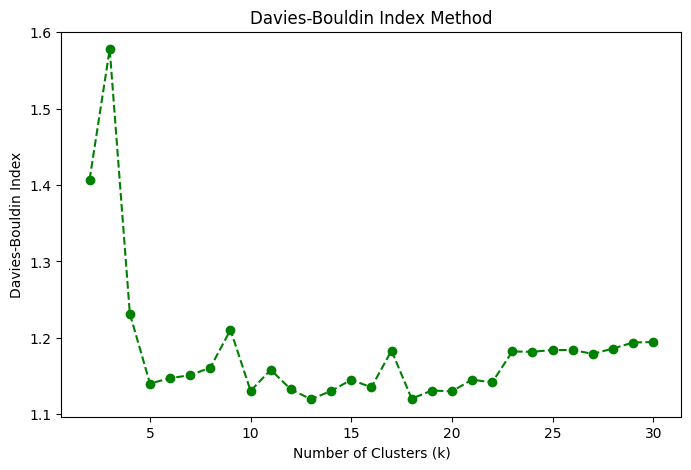

Optimal Number of Clusters: 13


In [ ]:
# 3. MiniBatch K-Means + DBI
def find_optimal_clusters(data, max_k, batch_size=1024):
    dbi_scores = []
    K_range = range(2, max_k + 1)

    for k in K_range:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=batch_size)
        labels = kmeans.fit_predict(data)

        dbi = davies_bouldin_score(data, labels)
        dbi_scores.append(dbi)

    plt.figure(figsize=(8, 5))
    plt.plot(K_range, dbi_scores, marker='o', linestyle='--', color='green')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Davies-Bouldin Index')
    plt.title('Davies-Bouldin Index Method')
    plt.show()
    optimal_k = np.argmin(dbi_scores) + 2
    return optimal_k

optimal_k = find_optimal_clusters(wave_data_scaled, max_k=30, batch_size=1024)
print(f"Optimal Number of Clusters: {optimal_k}")

Accident Ratio by Cluster:
Cluster
0     0.000011
1     0.000014
2     0.000000
3     0.000020
4     0.000034
5     0.000021
6     0.000058
7     0.000045
8     0.000015
9     0.000041
10    0.000000
11    0.000027
12    0.000017
Name: Accident, dtype: float64


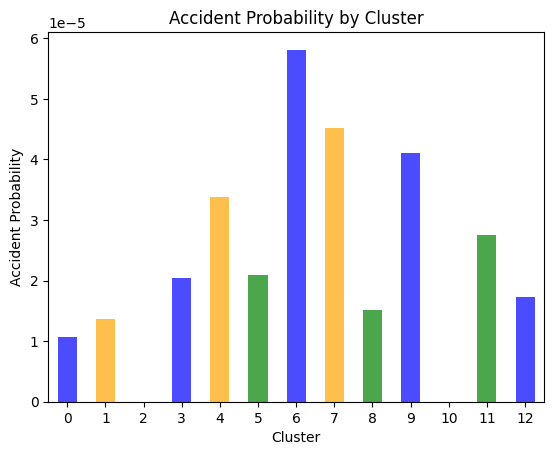


Cluster Centers:
         MWP         MWD       SWH  Wind_Speed  Wind_Direction
0   7.012271  327.665388  2.874637   11.616299      -59.805873
1   6.019008  134.574848  0.852671    3.696233       96.867859
2   7.099591  150.538279  2.253014    9.544441      113.419065
3   7.771111   79.752715  1.448798    4.491424     -127.822707
4   7.453882   42.723340  2.864886   11.434650     -127.780242
5   4.004769  292.342901  0.538741    4.049257      -33.641940
6   9.321190  137.823349  5.288177   16.191456      -24.335840
7   4.814713   65.285563  0.721864    4.566314     -124.675638
8   5.128169  170.468889  1.171866    7.812541       89.271184
9   3.750236  154.294593  0.455351    4.543401      103.324972
10  7.799640  100.670921  1.418685    4.394282      122.104521
11  5.532075  319.789685  1.476859    7.924999      -57.058679
12  6.091201   46.366694  1.655048    8.508958     -130.842960


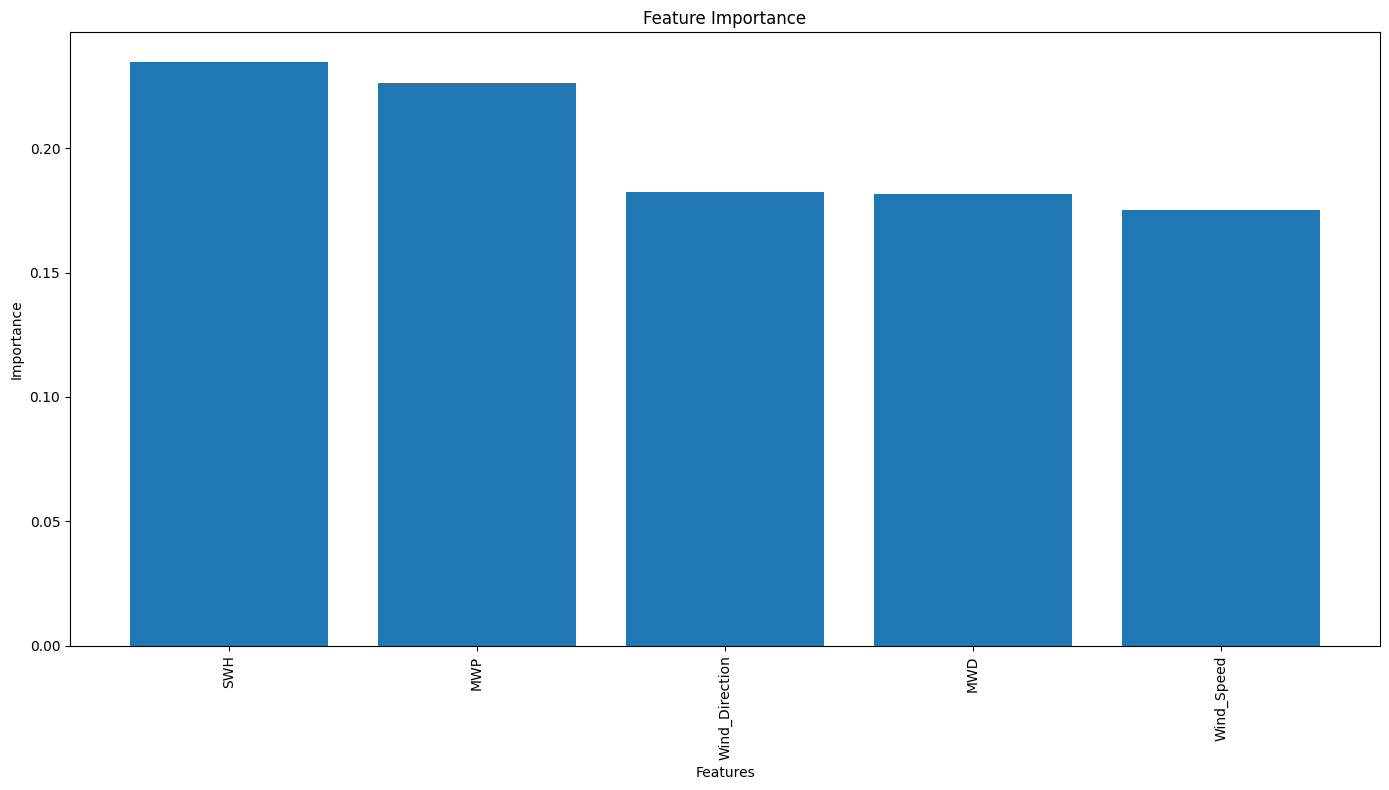

In [ ]:
# 4. Cluster Analysis
# KMeans
kmeans = KMeans(n_clusters=13, random_state=42)
wave_data['Cluster'] = kmeans.fit_predict(wave_data_scaled)

# Calculate the proportion of accidents in each cluster
cluster_accident_ratio = wave_data.groupby('Cluster')['Accident'].mean()
print("Accident Ratio by Cluster:")
print(cluster_accident_ratio)

# cluster_accident_ratio plot
cluster_accident_ratio.plot(kind='bar', color=['blue', 'orange', 'green'], alpha=0.7)
plt.title('Accident Probability by Cluster')
plt.ylabel('Accident Probability')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

# Output cluster centers
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features)
print("\nCluster Centers:")
print(cluster_centers)

# Feature Importance Analysis
def feature_importance_analysis(features, cluster_labels, feature_names):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(features, cluster_labels)
    importance = rf.feature_importances_

    plt.figure(figsize=(14, 8))
    sorted_idx = np.argsort(importance)[::-1]
    plt.bar(range(len(importance)), importance[sorted_idx])
    plt.xticks(range(len(importance)), np.array(feature_names)[sorted_idx], rotation=90)
    plt.title("Feature Importance")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

from sklearn.utils import resample
features_sampled, labels_sampled = resample(
    wave_data_scaled, wave_data['Cluster'], n_samples=30000, random_state=42
)
feature_importance_analysis(features_sampled, labels_sampled, features)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


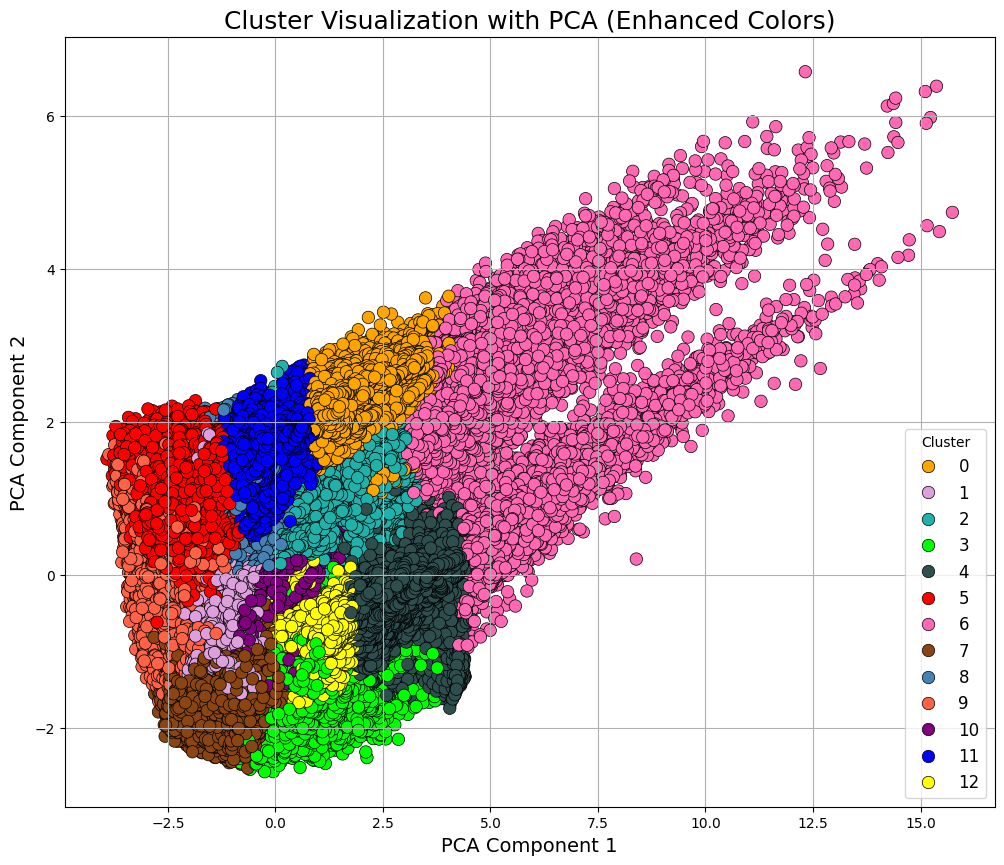

In [ ]:
# PCA reduces dimension to two dimensions
pca = PCA(n_components=2)
wave_data_pca = pca.fit_transform(wave_data_scaled)

wave_data['PCA1'] = wave_data_pca[:, 0]
wave_data['PCA2'] = wave_data_pca[:, 1]

custom_colors = [
    "#ff0000", "#0000ff", "#00ff00", "#800080", "#ffa500",
    "#ffff00", "#8b4513", "#ff69b4", "#2f4f4f", "#20b2aa",
    "#ff6347", "#4682b4", "#dda0dd", "#7fff00", "#ff4500"
]
unique_clusters = wave_data['Cluster'].unique()

if len(custom_colors) < len(unique_clusters):
    raise ValueError("Custom color list needs more colors for the number of clusters.")

cluster_palette = {cluster: custom_colors[i] for i, cluster in enumerate(unique_clusters)}

plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette=cluster_palette,
    data=wave_data,
    s=80,
    edgecolor="black",
    linewidth=0.5
)
plt.title('Cluster Visualization with PCA (Enhanced Colors)', fontsize=18)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.grid(True)
plt.show()

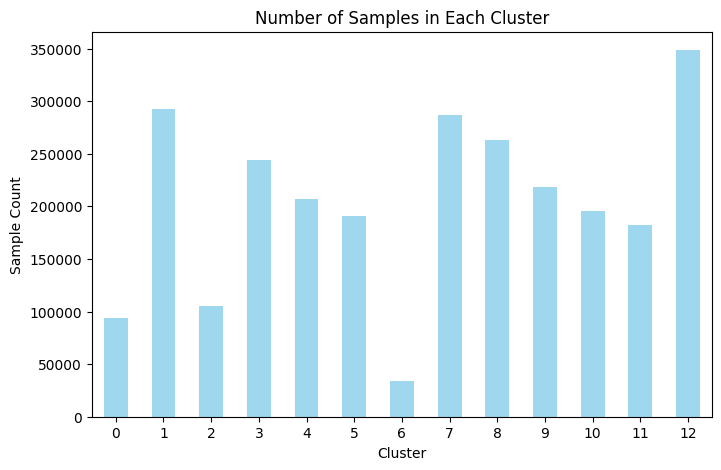

In [ ]:
# 5. Visualization
# (1) Sample size distribution
cluster_counts = wave_data['Cluster'].value_counts()
plt.figure(figsize=(8, 5))
cluster_counts.sort_index().plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Number of Samples in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Sample Count')
plt.xticks(rotation=0)
plt.show()

<ipython-input-30-d3df76e6ff04>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=wave_data, palette='Set2')


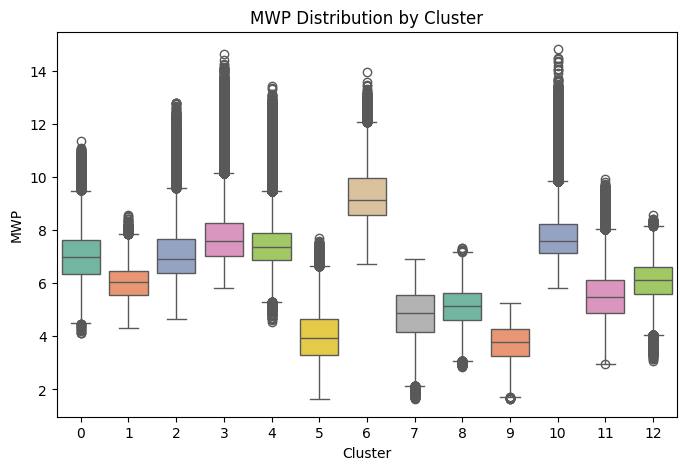

<ipython-input-30-d3df76e6ff04>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=wave_data, palette='Set2')


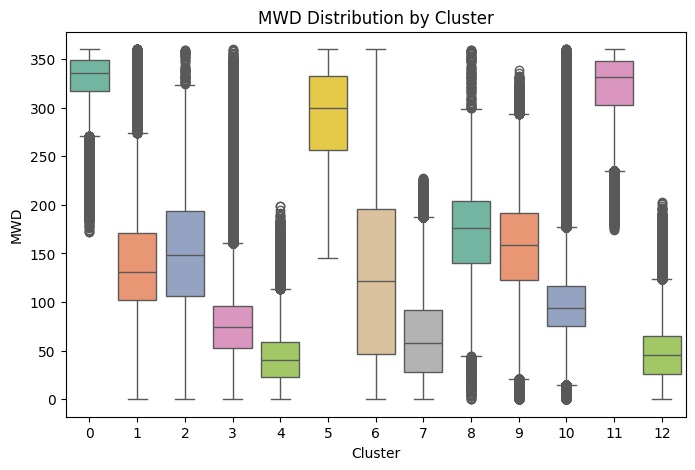

<ipython-input-30-d3df76e6ff04>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=wave_data, palette='Set2')


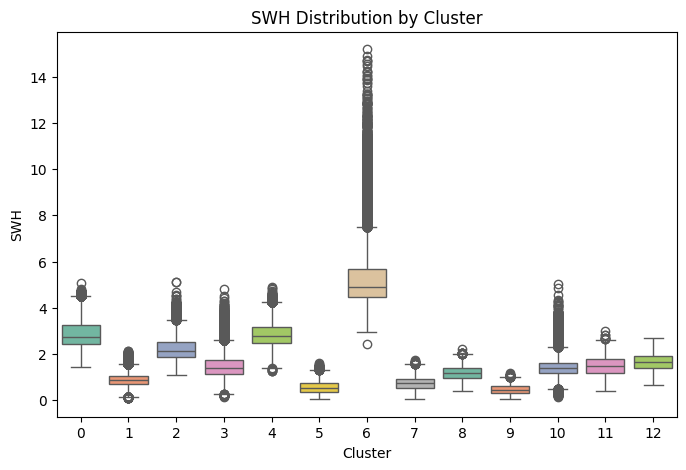

<ipython-input-30-d3df76e6ff04>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=wave_data, palette='Set2')


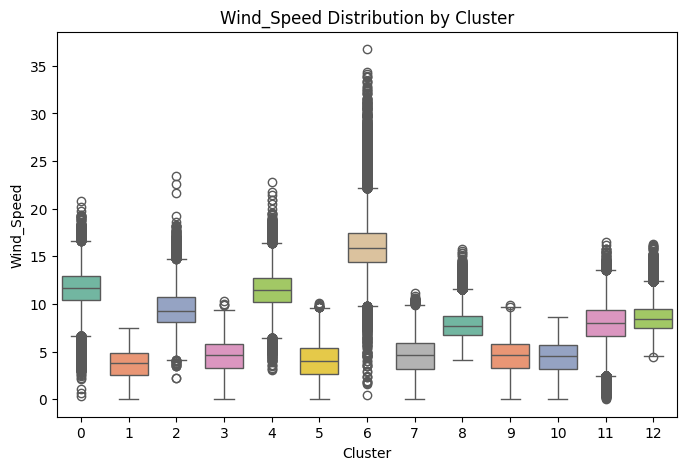

<ipython-input-30-d3df76e6ff04>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=wave_data, palette='Set2')


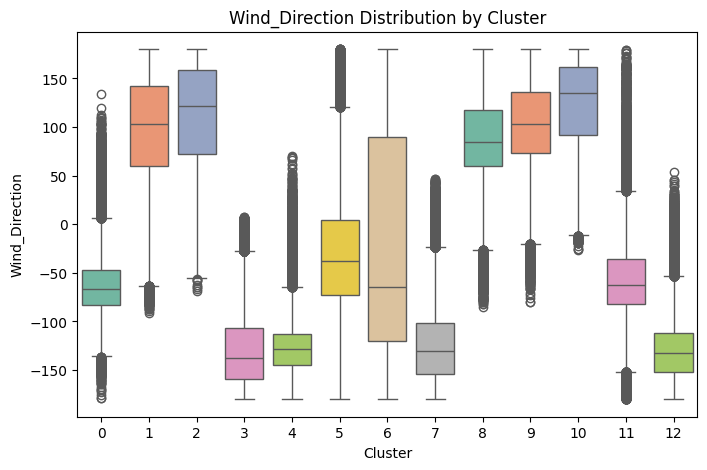

In [ ]:
# (2) Feature distribution (box plot)
for feature in features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Cluster', y=feature, data=wave_data, palette='Set2')
    plt.title(f'{feature} Distribution by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()

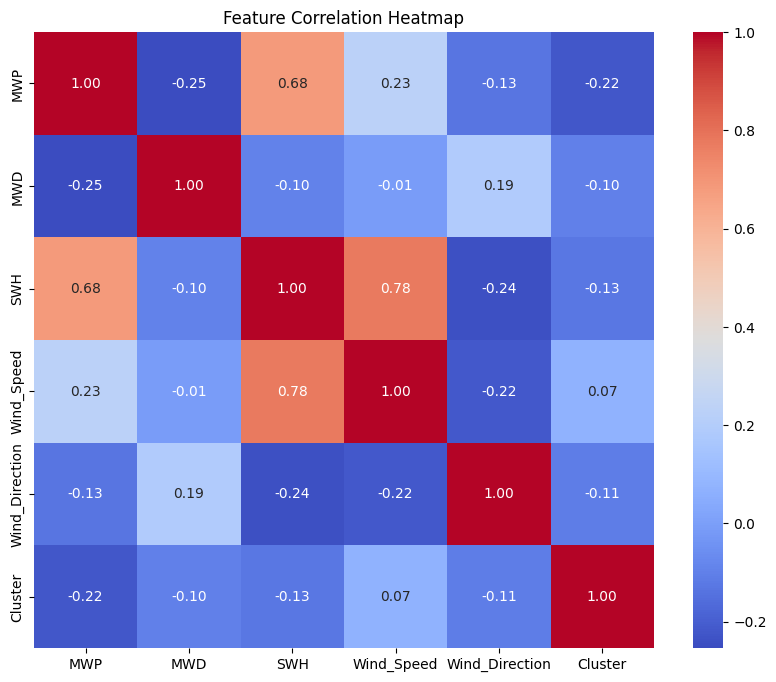

In [ ]:
# (3) Draw a feature correlation heat map
corr_matrix = wave_data[features + ['Cluster']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


In [ ]:
# (4) Generate heat map based on clustering results
lat_min, lat_max = 20, 40
lon_min, lon_max = 120, 130
wave_data = wave_data[(wave_data['Latitude'] >= lat_min) & (wave_data['Latitude'] <= lat_max) &
                      (wave_data['Longitude'] >= lon_min) & (wave_data['Longitude'] <= lon_max)]

grid_size = 0.25
wave_data['Lat_bin'] = np.floor(wave_data['Latitude'] / grid_size) * grid_size
wave_data['Lon_bin'] = np.floor(wave_data['Longitude'] / grid_size) * grid_size

# Statistical analysis of the accident probability of each cluster by grid and cluster
grid_cluster_accident = wave_data.groupby(['Lat_bin', 'Lon_bin','Cluster'])['Accident'].mean().reset_index()
grid_cluster_accident.columns = ['Latitude', 'Longitude', 'Cluster', 'Accident_Probability']

center_lat, center_lon = (lat_min + lat_max) / 2, (lon_min + lon_max) / 2
heatmap_map = folium.Map(location=[center_lat, center_lon], zoom_start=2)

for cluster_id in grid_cluster_accident['Cluster'].unique():
    cluster_data = grid_cluster_accident[grid_cluster_accident['Cluster'] == cluster_id]
    heat_data = cluster_data[['Latitude', 'Longitude', 'Accident_Probability']].values.tolist()

    HeatMap(heat_data, radius=15, blur=8, max_zoom=6, name=f"Cluster {cluster_id}").add_to(heatmap_map)

folium.LayerControl().add_to(heatmap_map)

heatmap_map.save('clustered_accident_heatmap3.html')
print("Clustered accident heatmap saved as 'clustered_accident_heatmap.html'")

Clustered accident heatmap saved as 'clustered_accident_heatmap.html'


In [ ]:
import folium
from folium.plugins import HeatMap


lat_min, lat_max = 20, 40
lon_min, lon_max = 120, 130


wave_data_filtered = wave_data[(wave_data['Latitude'] >= lat_min) & (wave_data['Latitude'] <= lat_max) &
                               (wave_data['Longitude'] >= lon_min) & (wave_data['Longitude'] <= lon_max)]

grid_size = 0.25
wave_data_filtered['Lat_bin'] = np.floor(wave_data_filtered['Latitude'] / grid_size) * grid_size
wave_data_filtered['Lon_bin'] = np.floor(wave_data_filtered['Longitude'] / grid_size) * grid_size

features_to_analyze = ['MWP', 'MWD', 'SWH', 'Wind_Speed', 'Wind_Direction']


center_lat, center_lon = (lat_min + lat_max) / 2, (lon_min + lon_max) / 2
heatmap_map = folium.Map(location=[center_lat, center_lon], zoom_start=6)


for feature in features_to_analyze:
    for cluster_id in wave_data_filtered['Cluster'].unique():

        grid_cluster_feature = wave_data_filtered[wave_data_filtered['Cluster'] == cluster_id].groupby(
            ['Lat_bin', 'Lon_bin'])[feature].mean().reset_index()
        grid_cluster_feature.columns = ['Latitude', 'Longitude', feature]


        heat_data = grid_cluster_feature[['Latitude', 'Longitude', feature]].values.tolist()

        layer_name = f"Cluster {cluster_id} - {feature}"
        feature_layer = folium.FeatureGroup(name=layer_name)
        HeatMap(heat_data, radius=15, blur=8, max_zoom=8).add_to(feature_layer)
        feature_layer.add_to(heatmap_map)


folium.LayerControl(collapsed=False).add_to(heatmap_map)


heatmap_map.save('clustered_feature_heatmaps.html')
print("Clustered feature heatmaps saved as 'clustered_feature_heatmaps.html'")



Clustered feature heatmaps saved as 'clustered_feature_heatmaps.html'
